In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Embedding, SimpleRNN, LSTM, Conv1D, GlobalMaxPooling1D, Dropout
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

num_words = 10000
max_review_len = 100
csv_path = '../build/data3.csv'
out_path = '../output/'

def lstm_model():
    model = Sequential()
    model.add(Embedding(num_words, 64, input_length=max_review_len))
    model.add(LSTM(128))
    model.add(Dense(1, activation='sigmoid'))
    return model
    
def rec_model():
    model = Sequential()
    model.add(Embedding(num_words, 2, input_length=max_review_len))
    model.add(SimpleRNN(8))
    model.add(Dense(1, activation='sigmoid'))
    return model

def conv_model():
    model = Sequential()
    model.add(Embedding(num_words, 64, input_length=max_review_len))
    model.add(Conv1D(250, 5, padding='valid', activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

class Type:
    def __init__(self, type_name, model):
        self.model_path = out_path + type_name + '/best_model.h5'
        self.tokenizer_path = out_path + type_name + '/tokenizer.pickle'
        self.model = model
    
lstm = Type("lstm", lstm_model())
reccurent = Type("rec", rec_model())
conv = Type("conv", conv_model())
    
# Загружаем данные
train = pd.read_csv(csv_path)
# Формируем х и у
reviews = train['review']
y_train = train['helpful']

# Обучаем токенизатор и сохраняем
net_type = lstm
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(reviews)
with open(net_type.tokenizer_path, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# Преобразуем х
sequences = tokenizer.texts_to_sequences(reviews)
x_train = pad_sequences(sequences, maxlen=max_review_len)

# Сборка модели
model = net_type.model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Сохраним лучшую модель
checkpoint_callback = ModelCheckpoint(net_type.model_path,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

# Обучаем
history = model.fit(x_train,
                    y_train,
                    epochs=5,
                    batch_size=128,
                    validation_split=0.1,
                    callbacks=[checkpoint_callback])

c:\users\a\appdata\local\programs\python\python37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 58989 samples, validate on 6555 samples
Epoch 1/5
58989/58989 [==============================] - 304s 5ms/step - loss: 0.6000 - accuracy: 0.6759 - val_loss: 0.5698 - val_accuracy: 0.7097

Epoch 00001: val_accuracy improved from -inf to 0.70969, saving model to ../output/lstm/best_model.h5
Epoch 2/5
58989/58989 [==============================] - 268s 5ms/step - loss: 0.5370 - accuracy: 0.7300 - val_loss: 0.5647 - val_accuracy: 0.7056

Epoch 00002: val_accuracy did not improve from 0.70969
Epoch 3/5
58989/58989 [==============================] - 266s 5ms/step - loss: 0.5046 - accuracy: 0.7481 - val_loss: 0.5872 - val_accuracy: 0.6941

Epoch 00003: val_accuracy did not improve from 0.70969
Epoch 4/5
58989/58989 [==============================] - 271s 5ms/step - loss: 0.4754 - accuracy: 0.7657 - val_loss: 0.6069 - val_accuracy: 0.6952

Epoch 00004: val_accuracy did not improve from 0.70969
Epoch 5/5
58989/58989 [==============================] - 283s 5ms/step - loss: 0.4471 - accu

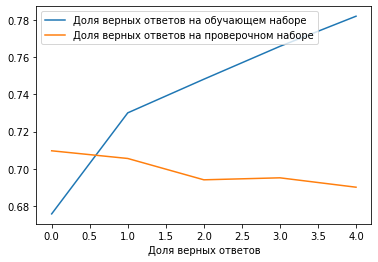

In [11]:
plt.plot(history.history['accuracy'],
         label = "Доля верных ответов на обучающем наборе")
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.xlabel('Доля верных ответов')
plt.legend()
plt.show()